In [1]:
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DeltaTutorial") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")

Spark and Delta Lake are ready!


In [13]:
data = [
(1, "John", "Electronics", 2, 300),
(2, "Sara", "Clothing", 1, 50),
(3, "Mike", "Electronics", 4, 600),
(4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)
# Save as Delta table
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

Managed vs Unmanaged Tables

In [16]:
spark.sql("CREATE TABLE orders_managed USING DELTA LOCATION '/tmp/orders_delta'")
spark.sql("CREATE TABLE orders_unmanaged USING DELTA LOCATION '/tmp/orders_delta'")

DataFrame[]

In [17]:
spark.sql("SHOW TABLES").show()

+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|  default|  orders_managed|      false|
|  default|orders_unmanaged|      false|
+---------+----------------+-----------+



CRUD Operations

In [18]:
# read
orders_df = spark.read.format("delta").load('/tmp/orders_delta')
orders_df.show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [19]:
# update
spark.sql("""
UPDATE delta.`/tmp/orders_delta`
SET amount = amount + 20
WHERE category = 'Clothing'
""")
spark.read.format("delta").load("/tmp/orders_delta").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



In [24]:
# delete
spark.sql("""
delete from delta.`/tmp/orders_delta`
where quantity < 2""")
spark.read.format("delta").load("/tmp/orders_delta").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



In [26]:
from delta.tables import DeltaTable

delta_table = DeltaTable.forPath(spark, "/tmp/orders_delta")

new_data = [
    (2, "Sara", "Clothing", 1, 120),
    (5, "Alex", "Electronics", 1, 200)
]
new_df = spark.createDataFrame(new_data, columns)

delta_table.alias("t").merge(
    new_df.alias("s"),
    "t.order_id = s.order_id"
).whenMatchedUpdateAll() \
 .whenNotMatchedInsertAll() \
 .execute()

spark.read.format("delta").load("/tmp/orders_delta").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       2|         Sara|   Clothing|       1|   120|
|       5|         Alex|Electronics|       1|   200|
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



History & Time Travel

In [27]:
# History
spark.sql("describe history delta.`/tmp/orders_delta`").show()

# version 0
version0 = spark.read.format("delta").option("versionAsOf",0).load("/tmp/orders_delta")
version0.show()

# latest
latest =spark.read.format("delta").load("/tmp/orders_delta")
latest.show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      7|2025-08-14 05:29:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          6|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      6|2025-08-14 05:28:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|          5|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|      5|2

Incremental Load Pattern

In [29]:
# mini batch
new = [
    (6,"Tom","Clothing",2,80),
    (7,"Emma","Electronics",3,450)
    ]
batch = spark.createDataFrame(new,columns)

# append
batch.write.format("delta").mode("append").save('/tmp/orders_delta')

# final result
spark.read.format("delta").load('/tmp/orders_delta').show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       2|         Sara|   Clothing|       1|   120|
|       5|         Alex|Electronics|       1|   200|
|       7|         Emma|Electronics|       3|   450|
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       6|          Tom|   Clothing|       2|    80|
+--------+-------------+-----------+--------+------+



Simple Streaming Read

In [30]:
stream_df = (
    spark.readStream.format("delta")
    .load("/tmp/orders_delta")
)

query = (
    stream_df.writeStream
    .outputMode("append")
    .format("console")
    .trigger(processingTime="5 seconds")
    .start()
)

Visualization

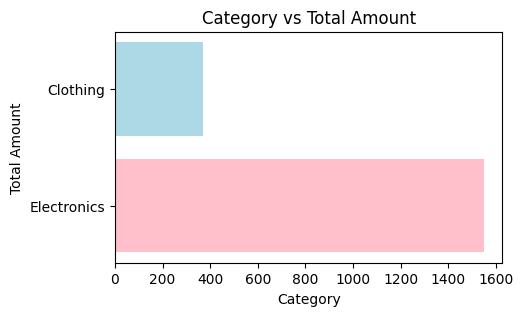

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum

cat_df = (
    spark.read.format("delta").load("/tmp/orders_delta")
    .groupBy("category")
    .agg(sum("amount").alias("total_amount"))
    .toPandas()
)
plt.figure(figsize=(5,3))
plt.barh(cat_df["category"], cat_df["total_amount"], color=['pink', 'lightblue'])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()
